In [15]:
import torch
from torch import nn, Tensor
import matplotlib.pyplot as plt
from  sklearn.datasets import make_moons

In [16]:
class Flow(nn.Module):
    def __init__(self, dim: int = 2, nb_neurons : int = 512):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim+1, nb_neurons),  # input dim + 1 for the time
            nn.ReLU(),
            nn.Linear(nb_neurons, nb_neurons),
            nn.ReLU(),
            nn.Linear(nb_neurons, nb_neurons),
            nn.ReLU(),
            nn.Linear(nb_neurons, nb_neurons),
            nn.ReLU(),
            nn.Linear(nb_neurons, dim))

    def forward(self, x_t: Tensor, t: Tensor) -> Tensor:
        return self.net(torch.cat([t, x_t], -1))
    
    def step(self, x_t: Tensor, t_start: Tensor, t_end: Tensor) -> Tensor:
        t_start = t_start.view(1,1).expand(x_t.shape[0], 1)  # broadcast t_start to match x_t shape
        return x_t + (t_end - t_start) * self(x_t + self(x_t, t_start) * (t_end - t_start) / 2,
                                               t_start + (t_end - t_start)  / 2)  # Midpoint rule


Training

In [17]:
flow = Flow()
optimizer = torch.optim.Adam(flow.parameters(), 1e-2)  # 1e-2 is the learning rate
loss_fn = nn.MSELoss()

for _ in range (10000):
    x_1 = Tensor(make_moons(256, noise=0.05)[0])
    x_0 = torch.randn_like(x_1)  # random normal distribution
    t = torch.rand(len(x_1), 1)  # random time between 0 and 1
    x_t = (1 - t) * x_0 + t * x_1
    dx_t = x_1 - x_0  
    optimizer.zero_grad()
    loss = loss_fn(flow(x_t, t), dx_t).backward() 
    optimizer.step()

Sampling

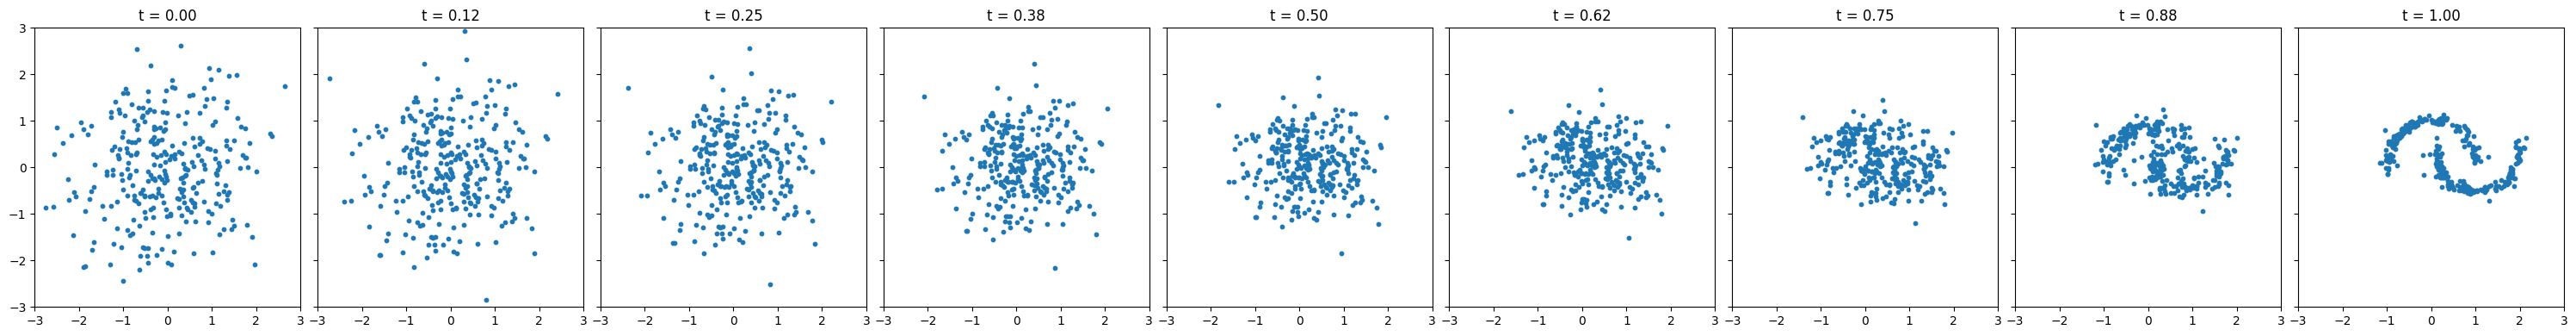

In [18]:
x = torch.randn(300, 2) # random normal distribution
n_steps = 8
fig, axes = plt.subplots(1, n_steps+1, figsize=(30, 4), sharex=True, sharey=True)
time_steps = torch.linspace(0, 1.0, n_steps+1)

axes[0].scatter(x.detach()[:, 0], x.detach()[:, 1], s=10)
axes[0].set_title(f't = {time_steps[0]:.2f}')
axes[0].set_xlim(-3.0, 3.0)
axes[0].set_ylim(-3.0, 3.0)

for i in range(n_steps):
    x = flow.step(x, time_steps[i], time_steps[i + 1])
    axes[i + 1].scatter(x.detach()[:, 0], x.detach()[:, 1], s=10)
    axes[i + 1].set_title(f't = {time_steps[i + 1]:.2f}')

plt.tight_layout()
plt.show()